# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! 

Try to apply the techniques you have learnt, but also feel free to come up with innovative ideas and test them.

In [1]:
import gym, os, sys, random, copy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import namedtuple, deque, defaultdict
from keras import layers, models, optimizers
from keras import backend as K
from keras.initializers import RandomUniform
from keras.regularizers import l2
%matplotlib inline

Using TensorFlow backend.


## The Agent

In [2]:
class DDPG():
    """Initialize an Agent object.

    Params
    ======
        env (obj): environment to use, for example an OpenAI gym environment
        random_seed (int): random seed
        max_eps (int): maximum number of episodes to run
        max_steps (int): maximum number of steps to take per episode if there is no hardcoded episode terminator
        train_every (str or int): set to 'step', 'episode', or int to train after every step, episode, or n number of steps
        decay_noise (str): program to decay noise. set to False, 'exp', 'linear', or 'success'
    """

    def __init__(self, env, env_type, random_seed, max_eps, max_steps, train_every, decay_noise):
        self.env = env
        self.env_type = env_type # Either 'openai' or 'copter'
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        self.action_low = env.action_space.low[0]
        self.action_high = env.action_space.high[0]
        self.seed = random_seed
        self.ep_num = 0  # Counter for episode number
        self.step_num = 1  # Counter for step number
        self.max_eps = max_eps  # Maximum number of episodes to run
        self.max_steps = max_steps  # Maximum number of steps per episode
        self.scale_state_vector = False  # True to apply min/max scaling on state vector
        self.record = defaultdict(list)  # Stores records of all states, actions, and rewards
        self.train_every = train_every  # Training frequency: 'step', 'episode', or int value (every n steps).
        self.decay_noise = decay_noise  # Set to False, 'exp', 'linear', or 'success' (default is False)

        # Actor (Policy) Model
        self.actor_local = Actor(state_size=self.state_size,
                                 action_size=self.action_size,
                                 action_low=self.action_low,
                                 action_high=self.action_high,
                                 seed=random_seed)

        self.actor_target = Actor(state_size=self.state_size,
                                  action_size=self.action_size,
                                  action_low=self.action_low,
                                  action_high=self.action_high,
                                  seed=random_seed)

        # Critic (Value) Model
        self.critic_local = Critic(state_size=self.state_size,
                                   action_size=self.action_size,
                                   seed=random_seed)

        self.critic_target = Critic(state_size=self.state_size,
                                    action_size=self.action_size,
                                    seed=random_seed)

        # Initialize target model parameters with local model parameters
        self.critic_target.model.set_weights(self.critic_local.model.get_weights())
        self.actor_target.model.set_weights(self.actor_local.model.get_weights())

        # Noise process
        self.exploration_mu = 0
        self.exploration_theta = 0.15
        self.exploration_sigma = 0.2

        self.initial_noise_scale = 1
        self.noise_scale = self.initial_noise_scale
        self.noise_decay_rate = 0.99
        self.noise = OUNoise(self.action_size,
                             random_seed,
                             self.exploration_mu,
                             self.exploration_theta,
                             self.exploration_sigma)

        # Replay memory
        self.buffer_size = int(1e5)  # replay buffer size
        self.batch_size = 128  # minibatch size
        self.sparse_reward_weight = False  # weighting factor for prioritized replay
        self.subsample_size = None  # size of subsample to use for prioritized replay
        self.memory = ReplayBuffer(self.buffer_size,
                                   self.batch_size,
                                   self.sparse_reward_weight,
                                   random_seed,
                                   self.subsample_size)

        # Algorithm parameters
        self.gamma = 0.99  # discount factor
        self.tau = 0.001  # for soft update of target parameters
        
    def reset(self, env, env_type, random_seed, max_eps, max_steps, train_every, decay_noise):
        """Reset agent to its initial state."""
        
        self.__init__(env, env_type, random_seed, max_eps, max_steps, train_every, decay_noise)
        
    def reset_episode(self):
        self.noise.reset()  # reset the OUNoise
        self.ep_num += 1  # increment the episode counter by 1
        self.step_num = 1  # reset the step counter to 1

    def increment_step(self):
        """Increment the step counter by 1."""
        self.step_num += 1

    def decay_noise_scale(self, done):
        """Decay the noise scale according to a specified program. This is called by the step method.
        Linear decay scales the action by p = ep_num/max_eps and the noise by 1 - p. Exponential decay
        reduces initial_noise_scale by noise_decay_rate^ep_num. The last option is to decay when there
        is a succesful episode. Here a success is defined as the episode terminating before max_steps
        is reached (i.e., if the agent reaches a goal), so it doesn't work for say Pendulum, but works
        for MountainCar. But this can be easily adapted for other defs of success."""

        # Linear decay
        if self.decay_noise == 'linear':
            p = self.ep_num / self.max_eps
            self.noise_scale = 1 - p

        # Exponential decay
        if self.decay_noise == 'exp':
            self.noise_scale = self.initial_noise_scale * (self.noise_decay_rate ** self.ep_num)

        # Decay upon successful episode
        if self.decay_noise == 'success':
            if done and (self.step_num < self.max_steps):
                self.noise_scale *= self.noise_decay_rate

    def store_record(self, state, action, reward, done):
        """Store experience in record for analysis."""

        for i in range(len(state)):
            self.record['State ' + str(i)].append(state[i])
        for i in range(len(action)):
            self.record['Action ' + str(i)].append(action[i])
        self.record['Reward'].append(reward)
        self.record['Done'].append(done)
        self.record['Noise scale'].append(self.noise_scale)
        self.record['Episode'].append(self.ep_num)
        self.record['Step'].append(self.step_num)
        
        if self.env_type == 'copter':
            dims = ['x', 'y', 'z']
            for i in range(len(self.env.sim.v)):
                self.record['Lin_v ' + dims[i]].append(self.env.sim.v[i])
            for i in range(len(self.env.sim.angular_v)):
                self.record['Ang_v ' + str(i)].append(self.env.sim.angular_v[i])

    def step(self, state, action, reward, next_state, done):
        # Save experience/reward in record for later analysis (do this before scaling state vector)
        self.store_record(state, action, reward, done)
        
        # Save experience/reward in Replay Buffer
        self.memory.add(state, action, reward, next_state, done)

        # Train depending on frequency desired (every ep, every step, every n steps)
        if self.train_every == 'episode':
            if done or (self.step_num == self.max_steps):
                # Learn, if enough samples are available in memory
                if len(self.memory) > self.batch_size:
                    experiences = self.memory.sample()
                    self.learn(experiences)
        elif self.train_every == 'step':
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)
        elif type(self.train_every) == int:
            if self.step_num % self.train_every == 0:
                if len(self.memory) > self.batch_size:
                    experiences = self.memory.sample()
                    self.learn(experiences)

        # Increment step count by 1
        self.increment_step()

        # Decay noise scale
        self.decay_noise_scale(done)

    def act(self, state):
        """Returns actions for given state(s) as per current policy."""

        # Scale the state vector if desired.
        if self.scale_state_vector:
            state = self.scale_state(state)

        state = np.reshape(state, [-1, self.state_size])
        action = self.actor_local.model.predict(state)[0]

        # Decay noise if desired (see decay_noise_scale method).
        if self.decay_noise == 'linear':
            action = action * (1 - self.noise_scale) + (self.noise_scale * self.noise.sample())
        else:
            action += self.noise_scale * self.noise.sample()

        return list(np.clip(action, self.action_low, self.action_high))

    def learn(self, experiences):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = rewards + γ * critic_target(next_states, actor_target(next_states))
        """
        # Convert experience tuples to separate arrays for each element (states, actions, rewards, etc.)
        states = np.vstack([e.state for e in experiences if e is not None])
        if self.scale_state_vector:
            states = self.scale_state(states)
        actions = np.array([e.action for e in experiences if e is not None]).astype(np.float32).reshape(-1,
                                                                                                        self.action_size)
        rewards = np.array([e.reward for e in experiences if e is not None]).astype(np.float32).reshape(-1, 1)
        dones = np.array([e.done for e in experiences if e is not None]).astype(np.uint8).reshape(-1, 1)
        next_states = np.vstack([e.next_state for e in experiences if e is not None])
        if self.scale_state_vector:
            next_states = self.scale_state(next_states)

        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target.model.predict_on_batch(next_states)
        Q_targets_next = self.critic_target.model.predict_on_batch([next_states, actions_next])

        # Compute Q targets for current states and train critic model (local)
        Q_targets = rewards + self.gamma * Q_targets_next * (1 - dones)
        self.critic_local.model.train_on_batch(x=[states, actions], y=Q_targets)

        # Train actor model (local)
        action_gradients = np.reshape(self.critic_local.get_action_gradients([states, actions, 0]),
                                      (-1, self.action_size))
        self.actor_local.train_fn([states, action_gradients, 1])  # custom training function

        # Soft-update target models
        self.soft_update(self.critic_local.model, self.critic_target.model)
        self.soft_update(self.actor_local.model, self.actor_target.model)

    def soft_update(self, local_model, target_model):
        """Soft update model parameters."""
        local_weights = np.array(local_model.get_weights())
        target_weights = np.array(target_model.get_weights())

        assert len(local_weights) == len(target_weights), "Local and target model parameters must have the same size"

        new_weights = self.tau * local_weights + (1 - self.tau) * target_weights
        target_model.set_weights(new_weights)

    def scale_state(self, state):
        """Min-max scaler for state vector."""

        mins = np.array([self.env.observation_space.low[i] for i in range(self.env.observation_space.shape[0])])
        maxes = np.array([self.env.observation_space.high[i] for i in range(self.env.observation_space.shape[0])])

        return np.divide(state - mins, maxes - mins)
    
    def train_agent(self, threshold=False):
        """Train agent in environment. Environment can be either 'copter' or 'openai'."""
        
        scores = []
        scores_deque = deque(maxlen=10)
        
        if threshold:
            trained = False
            while trained == False:
                for _ in range(1, self.max_eps + 1):
                    state = self.env.reset() # start a new episode
                    self.reset_episode()
                    score = 0
                    while True:
                        action = self.act(state)
                        if self.env_type == 'copter':
                            next_state, reward, done = self.env.step(action)
                        elif self.env_type == 'openai':
                            next_state, reward, done, _ = self.env.step(action)
                        self.step(state, action, reward, next_state, done)
                        state = next_state
                        score += reward
                        if done:
                            scores.append(score)
                            scores_deque.append(score)
                            if self.env_type == 'copter':
                                print("Episode {}/{}, score = {:.1f}, Noise = {:.3f}, Time = {:.2f}, Final State: ({:.2f}, {:.2f}, {:.2f})"
                                      .format(self.ep_num, self.max_eps, score, self.noise_scale, 
                                              self.env.sim.time, state[0], state[1], state[2]))
                            elif self.env_type == 'openai':
                                print("Episode {}/{}, score = {:.1f}, Noise = {:.3f}"
                                      .format(self.ep_num,  self.max_eps, score, self.noise_scale))
                            break

                    if (self.ep_num % 10 == 0):
                        if (np.mean(scores_deque) < threshold):
                            print('Agent failed to learn or got stuck in local minimum: Resetting networks and trying again.')
                            self.reset(self.env, self.env_type, self.seed, max_eps=self.max_eps, max_steps=self.max_steps, 
                                       train_every=self.train_every, decay_noise=self.decay_noise)
                            break
                    if self.ep_num == self.max_eps:
                        print('Agent trained succesfully!')
                        trained = True
                        break
                            
        else:
            for _ in range(1, self.max_eps + 1):
                    state = self.env.reset() # start a new episode
                    self.reset_episode()
                    score = 0
                    while True:
                        action = self.act(state)
                        if self.env_type == 'copter':
                            next_state, reward, done = self.env.step(action)
                        elif self.env_type == 'openai':
                            next_state, reward, done, _ = self.env.step(action)
                        self.step(state, action, reward, next_state, done)
                        state = next_state
                        score += reward
                        if done:
                            scores.append(score)
                            if self.env_type == 'copter':
                                print("Episode {}/{}, score = {:.1f}, Noise = {:.3f}, Time = {:.2f}, Final State: ({:.2f}, {:.2f}, {:.2f})"
                                      .format(self.ep_num,self.max_eps, score, self.noise_scale, 
                                              self.env.sim.time, state[0], state[1], state[2]))
                            elif self.env_type == 'openai':
                                print("Episode {}/{}, score = {:.1f}, Noise = {:.3f}"
                                      .format(self.ep_num,  self.max_eps, score, self.noise_scale))
                            break
                    
        return scores
    
    def watch_agent(self):
        """Watch a trained agent's performance in an environment."""
        
        self.ep_num = 0
        
        scores = []
        for _ in range(1, self.max_eps + 1):
            state = self.env.reset() # start a new episode
            self.reset_episode()
            score = 0
            while True:
                action = self.act(state)
                if self.env_type == 'copter':
                    state, reward, done = self.env.step(action)
                elif self.env_type == 'openai':
                    state, reward, done, _ = self.env.step(action)
                    if self.ep_num % 10 == 0:
                        self.env.render()
                score += reward
                if done:
                    scores.append(score)
                    if self.env_type == 'copter':
                        print("Episode {}/{}, score = {:.1f}, Noise = {:.3f}, Time = {:.2f}, Final State: ({:.2f}, {:.2f}, {:.2f})"
                              .format(self.ep_num, self.max_eps, score, self.noise_scale, 
                                      self.env.sim.time, state[0], state[1], state[2]))
                    elif self.env_type == 'openai':
                        print("Episode {}/{}, score = {:.1f}, Noise = {:.3f}"
                              .format(self.ep_num, self.max_eps, score, self.noise_scale))
                    break
                    
        return scores
        
        
class Actor:
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, action_low, action_high, seed):
        """Initialize parameters and build model.

        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            action_low (array): Min value of each action dimension
            action_high (array): Max value of each action dimension
        """
        self.state_size = state_size
        self.action_size = action_size
        self.action_low = action_low
        self.action_high = action_high
        self.action_range = self.action_high - self.action_low
        self.seed = seed

        self.build_model()

    def build_model(self):
        """Build an actor (policy) network that maps states -> actions."""
        # Define input layer (states)
        states = layers.Input(shape=(self.state_size,), name='states')

        # Add hidden layers
        kernel_init_hl1 = RandomUniform(minval=-1/np.sqrt(400), maxval=1/np.sqrt(400), seed=self.seed)
        net = layers.Dense(units=400, activation='relu', kernel_initializer=kernel_init_hl1)(states)
        kernel_init_hl2 = RandomUniform(minval=-1 / np.sqrt(300), maxval=1 / np.sqrt(300), seed=self.seed)
        net = layers.Dense(units=300, activation='relu', kernel_initializer=kernel_init_hl2)(net)
        kernel_init_hl3 = RandomUniform(minval=-1 / np.sqrt(200), maxval=1 / np.sqrt(200), seed=self.seed)
        net = layers.Dense(units=200, activation='relu', kernel_initializer=kernel_init_hl3)(net)

        #  Add final output layer with sigmoid activation
        kernel_init_out = RandomUniform(minval=-3e-3, maxval=3e-3, seed=self.seed)
        raw_actions = layers.Dense(units=self.action_size, activation='sigmoid', kernel_initializer=kernel_init_out,
                                   name='raw_actions')(net)

        # Scale [0, 1] output for each action dimension to proper range
        actions = layers.Lambda(lambda x: (x * self.action_range) + self.action_low, name='actions')(raw_actions)

        # Create Keras model
        self.model = models.Model(inputs=states, outputs=actions)

        # Define loss function using action value (Q value) gradients
        action_gradients = layers.Input(shape=(self.action_size,))
        loss = K.mean(-action_gradients * actions)

        # Define optimizer and training function
        optimizer = optimizers.Adam(lr=1e-3)
        updates_op = optimizer.get_updates(params=self.model.trainable_weights, loss=loss)
        self.train_fn = K.function(
            inputs=[self.model.input, action_gradients, K.learning_phase()],
            outputs=[],
            updates=updates_op)


class Critic:
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.

        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = seed

        self.build_model()

    def build_model(self):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        # Define input layers
        states = layers.Input(shape=(self.state_size,), name='states')
        actions = layers.Input(shape=(self.action_size,), name='actions')

        # Add hidden layer(s) for state pathway
        kernel_init_hl1 = RandomUniform(minval=-1/np.sqrt(400), maxval=1/np.sqrt(400), seed=self.seed)
        net_states = layers.Dense(units=400, activation='relu', kernel_initializer=kernel_init_hl1)(states)

        # Combine state and action pathways
        state_action = layers.Concatenate()([net_states, actions])

        # Add hidden layer(s) for combined state/action pathway
        kernel_init_hl2 = RandomUniform(minval=-1/np.sqrt(300), maxval=1/np.sqrt(300), seed=self.seed)
        net = layers.Dense(units=300, activation='relu', kernel_initializer=kernel_init_hl2)(state_action)
        kernel_init_hl3 = RandomUniform(minval=-1/np.sqrt(200), maxval=1/np.sqrt(200), seed=self.seed)
        net = layers.Dense(units=200, activation='relu', kernel_initializer=kernel_init_hl3)(net)

        # Add final output layer to produce action values (Q values)
        kernel_init_out = RandomUniform(minval=-3e-3, maxval=3e-3, seed=self.seed)
        Q_values = layers.Dense(units=1, name='q_values', kernel_initializer=kernel_init_out)(net)

        # Create Keras model
        self.model = models.Model(inputs=[states, actions], outputs=Q_values)

        # Define optimizer and compile model for training with built-in loss function
        optimizer = optimizers.Adam(lr=1e-2)
        self.model.compile(optimizer=optimizer, loss='mse')

        # Compute action gradients (derivative of Q values w.r.t. to actions)
        action_gradients = K.gradients(Q_values, actions)

        # Define an additional function to fetch action gradients (to be used by actor model)
        self.get_action_gradients = K.function(
            inputs=[*self.model.input, K.learning_phase()],
            outputs=action_gradients)

        
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, sparse_reward_weight, seed, subsample_size=None):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size: maximum size of buffer
            batch_size: size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size             # mini-batch size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.sparse_reward_weight = sparse_reward_weight
        self.seed = random.seed(seed)
        self.subsample_size = subsample_size     # subsample size for priority replay if replay buffer is large

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        if self.sparse_reward_weight:
            if self.sparse_reward_weight >= 1:
                self.sparse_reward_weight = 1 - 1e-8
            # Use a subsample of the memory if the memory is large to avoid slow performance
            if self.subsample_size is not None:
                if self.subsample_size > len(self.memory):  # This will only be True at the very beginning.
                    sorted_mem = sorted(self.memory, key=lambda x: x.reward, reverse=True)
                else:
                    subsample = random.sample(self.memory, k=self.subsample_size)
                    sorted_mem = sorted(subsample, key=lambda x: x.reward, reverse=True)
                prob = np.array([self.sparse_reward_weight ** i for i in range(len(sorted_mem))])
                prob /= np.sum(prob)
                indices = np.random.choice(np.arange(len(self.memory)), replace=False, size=self.batch_size, p=prob)
                sample_batch = np.array(sorted_mem)[indices]
                sample_batch = [self.experience(state, action, reward, next_state, done) for state, action, reward, next_state, done in sample_batch]
            else:
                sorted_mem = sorted(self.memory, key=lambda x: x.reward, reverse=True)
                prob = np.array([self.sparse_reward_weight ** i for i in range(len(sorted_mem))])
                prob /= np.sum(prob)
                indices = np.random.choice(np.arange(len(self.memory)), replace=False, size=self.batch_size, p=prob)
                sample_batch = np.array(sorted_mem)[indices]
                sample_batch = [self.experience(state, action, reward, next_state, done) for state, action, reward, next_state, done in sample_batch]
            return sample_batch
        else:
            return random.sample(self.memory, k=self.batch_size)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu, theta, sigma):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state

### The Task

In [3]:
from physics_sim import PhysicsSim
from scipy.spatial.distance import euclidean

class Task():
    """Task (environment) that defines the goal and provides feedback to the agent. Model this like the OpenAI Gym
    environments for compatibility with the same agents."""

    def __init__(self, init_pose=None, init_velocities=None, init_angle_velocities=None, runtime=5., target_pos=None):
        """
        Params
        ======
            init_pose: init position (x,y,z) of the quadcopter and the Euler angles phi (roll), theta (pitch), psi (yaw)
            init_velocities: init velocity (vx, vy, vz) of the quadcopter
            init_angle_velocities: init angular velocities in rad/s for each of the three Euler angles
            runtime: time limit for each episode
            target_pos: target/goal (x,y,z) position for the agent
        """

        # Simulation
        self.sim = PhysicsSim(init_pose, init_velocities, init_angle_velocities, runtime)
        self.action_low = 0
        self.action_high = 900
        self.low_state = np.array([-150.0, -150.0, 0.0, 0.0, 0.0, 0.0])
        self.high_state = np.array([150.0, 150.0, 300.0, 2 * np.pi, 2 * np.pi, 2 * np.pi])
        self.target_pos = target_pos if target_pos is not None else np.array([0., 0., 10.])
        self.action_repeat = 2
        self.state_size = self.action_repeat * 6
        self.action_size = 4

        self.observation_space = gym.spaces.Box(low=np.repeat(self.low_state, 2),
                                                high=np.repeat(self.high_state, 2),
                                                dtype=np.float32)

        self.action_space = gym.spaces.Box(low=self.action_low,
                                           high=self.action_high,
                                           shape=(4,),
                                           dtype=np.float32)

    def get_reward(self):
        """Uses current pose of sim to return reward."""
        delta_xy = euclidean(self.sim.pose[:2], self.target_pos[:2])
        max_delta_xy = euclidean(self.low_state[:2], self.high_state[:2])
        delta_z = self.sim.pose[2] - self.target_pos[2]
        max_delta_z = 300
        
        distance_penalty = (delta_xy / max_delta_xy) - 2 * (delta_z / max_delta_z)
        angular_penalty = (np.sum(self.sim.pose[3:]) / (6 * np.pi))
        velocity_reward = 2 * self.sim.v[2]
        velocity_penalty = abs(self.sim.v[1]) + abs(self.sim.v[0])

        reward = (1. - distance_penalty - angular_penalty + velocity_reward - velocity_penalty) / 10

        return reward

    def step(self, action):
        """Uses action (rotor speeds) to obtain next state, reward, done."""

        reward = 0
        pose_all = []
        for _ in range(self.action_repeat):
            done = self.sim.next_timestep(action)  # update the sim pose and velocities
            reward += self.get_reward()
            # Extra reward for reaching target position
            if self.sim.pose[2] >= self.target_pos[2]:
                reward += 100
                done = True
                # Extra reward/penalty for getting within +/- 5 of the target position in the xy plane
                if (self.sim.pose[0] - 5 < self.target_pos[0] < self.sim.pose[0] + 5) and (self.sim.pose[1] - 5 < self.target_pos[1] < self.sim.pose[1] + 5):
                    reward += 100
            # Extra penalty for running out of time
            if self.sim.time > self.sim.runtime:
                reward -= 100
            # Extra penalty going out of bounds (crashing)
            if np.any(self.sim.pose[:3] <= self.low_state[:3]) or np.any(self.sim.pose[:3] > self.high_state[:3]):
                reward -= 100
            pose_all.append(self.sim.pose)
        next_state = np.concatenate(pose_all)
        return next_state, reward, done

    def reset(self):
        """Reset the sim to start a new episode."""

        self.sim.reset()
        state = np.concatenate([self.sim.pose] * self.action_repeat) 
        return state

### Testing area

In [4]:
target_pos = np.array([0., 0., 130.])
task = Task(target_pos=target_pos)
agent = DDPG(env=task, env_type='copter', random_seed=None, max_eps=50, max_steps=False, train_every='step', decay_noise=False)

scores = agent.train_agent()

/Users/nate/Documents/Python/MachineLearningND/gym/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


Episode 1/50, score = -287.2, Noise = 1.000, Time = 5.04, Final State: (-15.27, 21.05, 19.47)
Episode 2/50, score = -572.1, Noise = 1.000, Time = 3.00, Final State: (-41.35, 9.44, 0.00)
Episode 3/50, score = -460.8, Noise = 1.000, Time = 2.76, Final State: (-25.91, 150.00, 70.94)
Episode 4/50, score = -421.2, Noise = 1.000, Time = 2.52, Final State: (-8.47, 12.40, 0.00)
Episode 5/50, score = -457.2, Noise = 1.000, Time = 1.72, Final State: (-2.09, 19.95, 0.00)
Episode 6/50, score = 1110.1, Noise = 1.000, Time = 4.88, Final State: (26.98, -10.74, 129.71)
Episode 7/50, score = 1289.7, Noise = 1.000, Time = 4.88, Final State: (-22.67, 3.64, 130.37)
Episode 8/50, score = 1276.9, Noise = 1.000, Time = 4.76, Final State: (5.23, 1.28, 129.82)
Episode 9/50, score = 1240.9, Noise = 1.000, Time = 4.76, Final State: (-12.36, -0.55, 129.83)
Episode 10/50, score = 1263.6, Noise = 1.000, Time = 4.92, Final State: (-28.23, 2.55, 130.06)
Episode 11/50, score = 1371.5, Noise = 1.000, Time = 4.72, Final

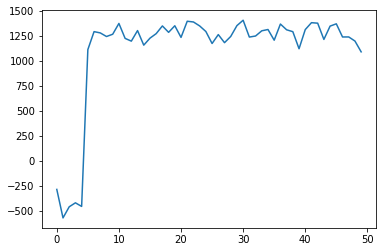

In [5]:
plt.plot(scores)

In [6]:
agent.watch_agent();

Episode 1/50, score = 1312.5, Noise = 1.000, Time = 4.76, Final State: (-4.40, -15.52, 130.50)
Episode 2/50, score = 1366.8, Noise = 1.000, Time = 4.72, Final State: (3.54, 4.75, 129.60)
Episode 3/50, score = 1387.3, Noise = 1.000, Time = 4.76, Final State: (0.29, 1.68, 129.92)
Episode 4/50, score = 1333.4, Noise = 1.000, Time = 4.80, Final State: (11.72, -3.14, 130.24)
Episode 5/50, score = 1248.5, Noise = 1.000, Time = 4.76, Final State: (-4.23, 8.78, 129.58)
Episode 6/50, score = 1378.9, Noise = 1.000, Time = 4.80, Final State: (6.85, 0.37, 130.54)
Episode 7/50, score = 1389.4, Noise = 1.000, Time = 4.76, Final State: (-0.83, 2.30, 129.98)
Episode 8/50, score = 1574.4, Noise = 1.000, Time = 4.76, Final State: (3.58, 2.10, 130.13)
Episode 9/50, score = 1593.6, Noise = 1.000, Time = 4.76, Final State: (-2.80, 0.73, 130.49)
Episode 10/50, score = 1342.7, Noise = 1.000, Time = 4.68, Final State: (0.24, 13.65, 130.60)
Episode 11/50, score = 1265.9, Noise = 1.000, Time = 4.72, Final State

## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

In [8]:
## TODO: Train your agent here.

## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

In [9]:
## TODO: Plot the rewards.

## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**:

**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**:

**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**:

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**: